# Data Prep

The goal of this notebook is to prep the data for the alignment task.  This includes computing audio features and generating a query list.

In [1]:
import numpy as np
import librosa as lb
import os
import os.path
from pathlib import Path
import multiprocessing
import glob
import pandas as pd
import matplotlib.pyplot as plt
import random
from itertools import combinations

Note that the Chopin_Mazurkas folder can be found in '/mnt/data0/Datasets/Chopin_Mazurkas'

In [2]:
ANNOTATIONS_ROOT = Path('Chopin_Mazurkas/annotations_beat')
AUDIO_ROOT = Path('Chopin_Mazurkas/wav_22050_mono')
FEATURES_ROOT = Path('features')
train_files = Path('cfg_files/train.txt')
test_files = Path('cfg_files/test.txt')

## Create filelists text files

In [5]:
def get_combinations(piece, filelist, seed=42):
    """
    For a given piece (ie. Chopin_Op017No4), return a list
    of tuples of all pair wise combinations between performances.
    """d
    performances = []
    with open(filelist, 'r') as infile:
        for performance in infile:
            if piece in performance:
                performances.append(performance.split())
    pairs = list(combinations(performances, 2))
    random.seed(seed)
    random.shuffle(pairs)
    return pairs

In [6]:
train_pairs = get_combinations('Chopin_Op017No4', train_files) + get_combinations('Chopin_Op063No3', train_files)
test_pairs = get_combinations('Chopin_Op024No2', test_files) + get_combinations('Chopin_Op030No2', test_files) + get_combinations('Chopin_Op068No3', test_files)

In [7]:
def create_file_list(pairs, outdir, limit=None):
    """ Save pairs to *.txt file """
    if limit:
        pairs = pairs[:limit]
    with open(outdir, 'w') as o:
        for a, b in pairs:
            o.write(f"{a[0]} {b[0]}\n")

In [8]:
# train-toy: randomly select 5 pairs from Op 17 #4
create_file_list(train_pairs, 'cfg_files/train_toy.txt', 5)
# train-small: randomly select 200 pairs from Op 17 #4
create_file_list(train_pairs, 'cfg_files/train_small.txt', 200)
# train-medium: includes all (63 choose 2) pairs for Op 17 #4
create_file_list(train_pairs, 'cfg_files/train_medium.txt', 1953)
# train-full: includes all (63 choose 2) + (88, choose 2) pairs for Op 17 #4 and Op 63 #3
create_file_list(train_pairs, 'cfg_files/train_full.txt')
# test-full: includes all pairs from the 3 test Mazurkas
create_file_list(test_pairs, 'cfg_files/test_full.txt')

## Delete exceptional pieces

In [9]:
try:
    os.remove("./Chopin_Mazurkas/wav_22050_mono/Chopin_Op017No4/Chopin_Op017No4_Ginzburg-1957_pid9156-10.wav")
    print("Removed Chopin_Op017No4/Chopin_Op017No4_Ginzburg-1957_pid9156-10")
except OSError:
    pass
try:
    os.remove("./Chopin_Mazurkas/wav_22050_mono/Chopin_Op068No3/Chopin_Op068No3_Koczalski-1948_pid9140-05.wav")
    print("Removed Chopin_Op068No3_Koczalski-1948_pid9140-05")
except OSError:
    pass

Removed Chopin_Op017No4/Chopin_Op017No4_Ginzburg-1957_pid9156-10
Removed Chopin_Op068No3_Koczalski-1948_pid9140-05


## Split into two training sets

In [23]:
filelists = ["train_toy", "train_small", "train_medium", "train_full", "test_full"]

Path('cfg_files/split1').mkdir(parents=True, exist_ok=True)
Path('cfg_files/split2').mkdir(parents=True, exist_ok=True)

def split_file(filelist):

    with open(f'cfg_files/{filelist}.txt', 'r') as i:
        lines = i.readlines()

    index = len(lines) // 2
    split1, split2 = lines[:index], lines[index:]

    with open(f'cfg_files/split1/{filelist}.txt', 'w') as o:
        for line in split1:
            o.write(line)

    with open(f'cfg_files/split2/{filelist}.txt', 'w') as o:
        for line in split2:
            o.write(line)

for filelist in filelists:
    split_file(filelist)

## Find median duration for each piece

In [24]:
def get_median():
    medians = {}
    dirs = glob.glob('Chopin_Mazurkas/wav_22050_mono/*/**/', recursive=True)
    for dir in dirs:
        piece = os.path.split(os.path.normpath(dir))[-1]
        performances = glob.glob(f'{dir}*.wav', recursive=True)
        durations = [lb.get_duration(filename=path) for path in performances]
        durations.sort()
        medians[piece] = durations[len(durations)//2]
    return medians

In [25]:
medians = get_median()
medians

{'Chopin_Op030No2': 87.30149659863946,
 'Chopin_Op063No3': 128.22149659863945,
 'Chopin_Op068No3': 99.64816326530612,
 'Chopin_Op024No2': 136.6748299319728,
 'Chopin_Op017No4': 254.92816326530613}

## Construct modified benchmark datasets

#### Create separate directories for each dataset

In [26]:
def create_mazurka_directories(factors, subseq=None): # subseq is used for creating the subsequence dataset folders
    '''create separate directories for each time scale modification'''
    for factor in factors:
        dir = None
        if subseq:
            dir = f'Mazurkas_median_x{factor}_subseq{subseq}'
        else:
            dir = f'Mazurkas_median_x{factor}'
        ann_dir = f'{dir}/annotations_beat'
        wav_dir = f'{dir}/wav_22050_mono'
        for mazurka in ['Chopin_Op017No4','Chopin_Op024No2','Chopin_Op030No2','Chopin_Op063No3','Chopin_Op068No3']:
            ann_piece_dir = f'{ann_dir}/{mazurka}'
            wav_piece_dir = f'{wav_dir}/{mazurka}'
            if not os.path.exists(ann_piece_dir):
                os.makedirs(ann_piece_dir)
            if not os.path.exists(wav_piece_dir):
                os.makedirs(wav_piece_dir)

In [27]:
factors = ['1.000','0.500','0.630','0.794','1.260','1.588','2.000']
create_mazurka_directories(factors, subseq=None)

## Perform time-scale modification

##### Generate .wav files

In [28]:
import soundfile as sf
import IPython.display as ipd
from tsm_tools import *
import pandas as pd

In [29]:
def time_scale_single(path_to_wav, median_duration, factor, outdir):
    '''time-scale modify for one .wav file'''
    y, sr = lb.load(path_to_wav)
    old_duration = lb.get_duration(y=y, sr=sr)
    ratio = (median_duration * factor) / old_duration
    y_mod = tsm_hybrid(y, alpha=ratio) # time scale modification
    new_path = f'{outdir}{path_to_wav[15:]}' # e.g. 'Mazurkas_median_x1.000/wav_22050_mono/Chopin_Op017No4/Chopin_Op017No4_Kitain-1937_pid9163-02.wav'
    sf.write(new_path, y_mod, sr)
    return

In [30]:
def time_scale_batch(filelist, piece, median_duration, factor, outdir, n_cores=40):
    '''time-scale modify for all .wav files for one mazurka for one factor'''
    inputs = []
    with open(filelist, 'r') as file:
        for line in file:
            if piece in line:
                # make path to .wav file
                path_to_wav = f'Chopin_Mazurkas/wav_22050_mono/{line[:-1]}.wav'
                inputs.append((path_to_wav, median_duration, factor, outdir))
    # process files in parallel
    pool = multiprocessing.Pool(processes=n_cores)
    pool.starmap(time_scale_single, inputs)

In [31]:
def time_scale_by_mazurka(filelist, piece, median_duration, factors):
    '''time-scale modify by all factors with one mazurka'''
    for factor in factors:
        time_scale_batch(filelist, piece, median_duration, float(factor),'Mazurkas_median_x{}'.format(factor))
        print(f"Done with Mazurkas_median_x{factor}/{piece}")

In [ ]:
time_scale_by_mazurka(train_files, 'Chopin_Op017No4', medians["Chopin_Op017No4"], factors)
time_scale_by_mazurka(train_files, 'Chopin_Op063No3', medians["Chopin_Op063No3"], factors)
time_scale_by_mazurka(test_files, 'Chopin_Op024No2', medians["Chopin_Op024No2"], factors)
time_scale_by_mazurka(test_files, 'Chopin_Op030No2', medians["Chopin_Op030No2"], factors)
time_scale_by_mazurka(test_files, 'Chopin_Op068No3', medians["Chopin_Op068No3"], factors)

## Generate .beat files

In [20]:
def getTimestamps(annotfile):
    df = pd.read_csv(annotfile, header=None, sep='\s+', skiprows=3)
    return np.array(df[0])

In [21]:
def create_beat_annotation(in_path_beat, in_path_wav, out_path, num_multiply): # num_multiply should be median*factor
    '''modifies beat annotations for one .wav file'''
    real_duration = lb.get_duration(filename=in_path_wav) # load .wav file to get original duration
    original_ts = getTimestamps(in_path_beat) # (median * factor) / real_dur
    modified_ts = (original_ts * num_multiply) / real_duration
    index = 0
    curr_read = 0
    new_lines = []
    with open(in_path_beat, 'r') as infile:
        for line in infile:
            if curr_read < 3: # copy first 3 lines
                new_lines.append(line)
                curr_read += 1
                continue
            else: # modify the rest of the lines
                label = line.split('\t')[-1]
                if index+1 == len(modified_ts):
                    curr_start, curr_end = modified_ts[index], 0.0
                else:
                    curr_start, curr_end = modified_ts[index], modified_ts[index+1]
                new_string = '{}\t{}\t{}'.format(curr_start, curr_end, label)
                new_lines.append(new_string)
                index += 1
    with open(out_path, 'w') as outfile:
        for line in new_lines:
            outfile.write(line)
    return new_lines

In [22]:
def create_beat_annotation_batch(filelist, piece, median_duration, factor, n_cores=40): # e.g. outdir is 'Mazurkas_median_x2.000/annotations_beat/Chopin_Op017No4'
    '''modifies beat annotations for all .wav files for one Mazurka for one factor'''
    inputs = []
    with open(filelist, 'r') as cfg_file:
        for line in cfg_file:
            if piece in line:
                path_to_beat = f'Chopin_Mazurkas/annotations_beat/{line[:-1]}.beat'
                path_to_wav = f'Chopin_Mazurkas/wav_22050_mono/{line[:-1]}.wav'
                out_path = f'Mazurkas_median_x{factor}/annotations_beat/{line[:-1]}.beat'
                num_multiply = median_duration * float(factor)
                inputs.append((path_to_beat, path_to_wav, out_path, num_multiply))
    # process files in parallel
    pool = multiprocessing.Pool(processes = n_cores)
    pool.starmap(create_beat_annotation, inputs)
    return

In [23]:
def beat_annotation_by_mazurka(filelist, piece, median_duration, factors):
    '''modifies beat annotations by all factors with one mazurka'''
    for factor in factors:
        create_beat_annotation_batch(filelist, piece, median_duration, factor)
        print(f"Done with Mazurkas_median_x{factor}/annotations_beat/{piece}")
    return

In [24]:
beat_annotation_by_mazurka(train_files, 'Chopin_Op017No4', medians["Chopin_Op017No4"], factors)
beat_annotation_by_mazurka(train_files, 'Chopin_Op063No3', medians["Chopin_Op063No3"], factors)
beat_annotation_by_mazurka(test_files, 'Chopin_Op024No2', medians["Chopin_Op024No2"], factors)
beat_annotation_by_mazurka(test_files, 'Chopin_Op030No2', medians["Chopin_Op030No2"], factors)
beat_annotation_by_mazurka(test_files, 'Chopin_Op068No3', medians["Chopin_Op068No3"], factors)

Done with Mazurkas_median_x1.000/annotations_beat/Chopin_Op017No4
Done with Mazurkas_median_x0.500/annotations_beat/Chopin_Op017No4
Done with Mazurkas_median_x0.630/annotations_beat/Chopin_Op017No4
Done with Mazurkas_median_x0.794/annotations_beat/Chopin_Op017No4
Done with Mazurkas_median_x1.260/annotations_beat/Chopin_Op017No4
Done with Mazurkas_median_x1.588/annotations_beat/Chopin_Op017No4
Done with Mazurkas_median_x2.000/annotations_beat/Chopin_Op017No4
Done with Mazurkas_median_x1.000/annotations_beat/Chopin_Op063No3
Done with Mazurkas_median_x0.500/annotations_beat/Chopin_Op063No3
Done with Mazurkas_median_x0.630/annotations_beat/Chopin_Op063No3
Done with Mazurkas_median_x0.794/annotations_beat/Chopin_Op063No3
Done with Mazurkas_median_x1.260/annotations_beat/Chopin_Op063No3
Done with Mazurkas_median_x1.588/annotations_beat/Chopin_Op063No3
Done with Mazurkas_median_x2.000/annotations_beat/Chopin_Op063No3
Done with Mazurkas_median_x1.000/annotations_beat/Chopin_Op024No2
Done with 

### Compute features on all directories

In [36]:
def compute_chroma_single(infile, outfile, sr=22050, hop_length=512):
    y, sr = lb.core.load(infile, sr=sr)
    F = lb.feature.chroma_cqt(y, sr=sr, hop_length=hop_length, norm=2)
    np.save(outfile, F)
    return

In [37]:
def compute_chroma_batch(filelist, dir, outdir, n_cores=40): # outdir should be 'features/clean'
    '''compute features for each median directory e.g. for all .wav files in 'Mazurkas_median_x0.500' '''
    inputs = [] # prep inputs for parallelization
    with open(filelist, 'r') as f:
        for line in f:
            relpath = line.strip()
            reldir, fileid = os.path.split(relpath)
            featdir = dir / outdir / reldir
            featdir.mkdir(parents=True, exist_ok=True)
            featfile = (featdir / fileid).with_suffix('.npy')
            audiofile = (dir / Path('wav_22050_mono') / relpath).with_suffix('.wav')
            if os.path.exists(featfile):
                print(f"Skipping {featfile}")
            else:
                inputs.append((audiofile, featfile))
    # process files in parallel
    pool = multiprocessing.Pool(processes = n_cores)
    pool.starmap(compute_chroma_single, inputs)
    return

In [38]:
FEATS_CLEAN_DIR = FEATURES_ROOT / 'clean'
directories = ['Chopin_Mazurkas', 'Mazurkas_median_x0.500', 'Mazurkas_median_x0.630', 'Mazurkas_median_x0.794', 'Mazurkas_median_x1.000', 'Mazurkas_median_x1.260', 'Mazurkas_median_x1.588', 'Mazurkas_median_x2.000']

In [39]:
# compute chromas for each directory
for dir in directories:
    compute_chroma_batch(train_files, dir, FEATS_CLEAN_DIR)
    compute_chroma_batch(test_files, dir, FEATS_CLEAN_DIR)
    print(f"Finished generating features for {dir}")

Finished generating features for Chopin_Mazurkas
Finished generating features for Mazurkas_median_x0.500
Finished generating features for Mazurkas_median_x0.630
Finished generating features for Mazurkas_median_x0.794
Finished generating features for Mazurkas_median_x1.000
Finished generating features for Mazurkas_median_x1.260
Finished generating features for Mazurkas_median_x1.588
Finished generating features for Mazurkas_median_x2.000


## Verification

Ensure all audio durations are within 10 milliseconds of their intended duration.

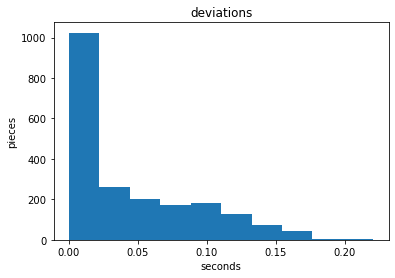

In [40]:
def verify_benchmark_durations(medians, tolerance = 1e-2):
    dirs = glob.glob('Mazurkas_median_*')
    deviations = []
    for dir in dirs:
        pieces = glob.glob(f'{dir}/wav_22050_mono/*/**/', recursive=True)
        for piece in pieces:
            factor, pieceid = os.path.split(os.path.normpath(piece))
            factor = float(os.path.split(factor)[0].split('_x')[1])
            recordings = glob.glob(f"{piece}/*")
            for recording in recordings:
                duration = lb.get_duration(filename=recording)
                deviation = abs(duration - (medians[pieceid] * factor))
                deviations.append(deviation)
    return deviations
deviations = verify_benchmark_durations(medians)
plt.hist(deviations)
plt.title("deviations")
plt.xlabel("seconds")
plt.ylabel("pieces")
plt.show()

Verify .beat files by examining example piece Chopin_Op017No4_Weissenberg-1971_pid9052b-09.wav x2.000.

In [41]:
create_beat_annotation('Chopin_Mazurkas/annotations_beat/Chopin_Op017No4/Chopin_Op017No4_Weissenberg-1971_pid9052b-09.beat', 'Chopin_Mazurkas/wav_22050_mono/Chopin_Op017No4/Chopin_Op017No4_Weissenberg-1971_pid9052b-09.wav', 'test.beat', medians["Chopin_Op017No4"]*2)[3:13]

['3.7878267363045808\t5.3110904403952945\t2\n',
 '5.3110904403952945\t6.407840307340608\t3\n',
 '6.407840307340608\t7.3217985297950365\t1\n',
 '7.3217985297950365\t8.174826204085836\t2\n',
 '8.174826204085836\t9.048164061097845\t3\n',
 '9.048164061097845\t10.043363014437112\t1\n',
 '10.043363014437112\t11.302594343152101\t2\n',
 '11.302594343152101\t13.435163528879098\t3\n',
 '13.435163528879098\t14.445099550800874\t1\n',
 '14.445099550800874\t17.77875607414859\t2\n']

In [42]:
real_duration = lb.get_duration(filename="Chopin_Mazurkas/wav_22050_mono/Chopin_Op017No4/Chopin_Op017No4_Weissenberg-1971_pid9052b-09.wav")
factor = medians["Chopin_Op017No4"] * 2 / real_duration
curr_read = 0
lines = []
with open('Chopin_Mazurkas/annotations_beat/Chopin_Op017No4/Chopin_Op017No4_Weissenberg-1971_pid9052b-09.beat', 'r') as infile:
    for line in infile:
        if curr_read < 3:
            curr_read += 1
            continue
        start, end, label = line.split('\t')
        start = factor * float(start)
        end = factor * float(end)
        lines.append(f"{start}\t{end}\t{label}")
        curr_read += 1
        if curr_read >= 13:
            break
lines

['3.787826736304581\t5.3110904403952945\t2\n',
 '5.3110904403952945\t6.407840307340609\t3\n',
 '6.407840307340609\t7.321798529795037\t1\n',
 '7.321798529795037\t8.174826204085836\t2\n',
 '8.174826204085836\t9.048164061097847\t3\n',
 '9.048164061097847\t10.04336301443711\t1\n',
 '10.04336301443711\t11.302594343152101\t2\n',
 '11.302594343152101\t13.4351635288791\t3\n',
 '13.4351635288791\t14.445099550800876\t1\n',
 '14.445099550800876\t17.77875607414859\t2\n']

# Generate Subsequence Dataset

In [7]:
from pydub import AudioSegment # NOTE: add pydub to environment file
import math

### Create directories

In [ ]:
# create a subsequence directory for each time factor (ex. 'Mazurkas_median_x1.000_subseq20')
factors = ['1.000','0.500','0.630','0.794','1.260','1.588','2.000']
create_mazurka_directories(factors, 20) # 20 for 'subseq20' directories

### Generate new .wav and .beat files

In [9]:
# get target durations for .wav files in subseq20 directories
medians = get_median()
medians_subseq = {key:medians[key]*0.2 for key in medians}
medians_subseq

{'Chopin_Op063No3': 25.644299319727892,
 'Chopin_Op068No3': 19.929632653061226,
 'Chopin_Op017No4': 50.98563265306123,
 'Chopin_Op024No2': 27.33496598639456,
 'Chopin_Op030No2': 17.46029931972789}

In [46]:
def get_start_end_times(total_dur, target_len): # everything in milliseconds
    '''select random time to get segment'''
    start = random.randint(0, math.floor(total_dur-target_len))
    end = start + target_len
    return start, end

In [96]:
def shift_beat_annotation(in_path_beat, out_path_beat, start_time, end_time): # start_time is in seconds
    '''shifts beat annotations for one .wav file'''
    original_ts = getTimestamps(in_path_beat)
    index = 0
    curr_read = 0
    new_lines = []
    with open(in_path_beat, 'r') as infile:
        for line in infile:
            if curr_read < 3: # copy first 3 lines
                new_lines.append(line)
                curr_read += 1
                continue
            else: # modify the rest of the lines
                info = line.split('\t')
                curr_start, curr_end, label = float(info[0]), float(info[1]), info[2]
                if(curr_end > end_time): # check that we haven't reached the end
                    break
                elif(curr_start > start_time):
                    curr_start, curr_end = curr_start-start_time, curr_end-start_time
                    if len(new_lines) == 3:      
                        label = '{}-{}\n'.format(label.strip(), index)
                    new_string = '{}\t{}\t{}'.format(curr_start, curr_end, label)
                    new_lines.append(new_string)
                index += 1

    with open(out_path_beat, 'w') as outfile:
        for line in new_lines:
            outfile.write(line)
    return new_lines

In [97]:
def subseq_single(path_to_wav, median_subseq, factor, outdir):
    '''modifies single .wav and .beat file pair'''
    
    # cut the .wav file into target segment
    new_audio = AudioSegment.from_wav(path_to_wav) # load old audio
    old_duration = new_audio.duration_seconds*1000
    start_time, end_time = get_start_end_times(old_duration, median_subseq*1000*float(factor)) # calculate time to modify to
    new_audio = new_audio[start_time:end_time] # cut the .wav file

    # save to new .wav file
    out_path_wav = '{}{}'.format(outdir, path_to_wav[22:]) # e.g. 'Mazurkas_median_x1.000_subseq20/wav_22050_mono/Chopin_Op017No4/Chopin_Op017No4_Kitain-1937_pid9163-02.wav'
    with open(out_path_wav, 'wb') as f:
        new_audio.export(f, format='wav')
    
    # make beat file
    in_path_beat = path_to_wav.replace('wav_22050_mono', 'annotations_beat').replace('.wav', '.beat')
    out_path_beat = '{}{}'.format(outdir, in_path_beat[22:])
    shift_beat_annotation(in_path_beat, out_path_beat, start_time/1000, end_time/1000)
    
    return


In [98]:
def subseq_batch(filelist, piece, median_subseq, factor, outdir, n_cores): # indir is e.g. 'Mazurkas_median_x0.500'
    '''modify for all .wav files for one mazurka for one factor'''
    inputs = []
    indir = 'Mazurkas_median_x{}'.format(factor)
    with open(filelist, 'r') as cfg_file:
        for line in cfg_file:
            if piece in line:
                # make path to .wav file
                path_to_wav = '{}/wav_22050_mono/{}.wav'.format(indir, line[:-1])
                inputs.append((path_to_wav, median_subseq, factor, outdir))
    # process files in parallel
    pool = multiprocessing.Pool(processes = n_cores)
    pool.starmap(subseq_single, inputs)
    return

In [101]:
def subseq_by_mazurka(filelist, piece, median_subseq, factors):
    '''modify by all factors with one mazurka'''
    for factor in factors:
        outdir = 'Mazurkas_median_x{}_subseq20'.format(factor)
        subseq_batch(filelist, piece, median_subseq, factor, outdir , 24)
        print("Done with Mazurkas_median_x{}_subseq20/{}".format(factor, piece))
    return
    

In [ ]:
subseq_by_mazurka(train_files, 'Chopin_Op017No4', medians_subseq["Chopin_Op017No4"], factors)
subseq_by_mazurka(train_files, 'Chopin_Op063No3', medians_subseq["Chopin_Op063No3"], factors)
subseq_by_mazurka(test_files, 'Chopin_Op024No2', medians_subseq["Chopin_Op024No2"], factors)
subseq_by_mazurka(test_files, 'Chopin_Op030No2', medians_subseq["Chopin_Op030No2"], factors)
subseq_by_mazurka(test_files, 'Chopin_Op068No3', medians_subseq["Chopin_Op068No3"], factors)

### Compute chroma features

In [10]:
FEATS_CLEAN_DIR = FEATURES_ROOT / 'clean'
directories = ['Chopin_Mazurkas', 'Mazurkas_median_x0.500_subseq20', 'Mazurkas_median_x0.630_subseq20', 'Mazurkas_median_x0.794_subseq20', 'Mazurkas_median_x1.000_subseq20', 'Mazurkas_median_x1.260_subseq20', 'Mazurkas_median_x1.588_subseq20', 'Mazurkas_median_x2.000_subseq20']

In [14]:
# compute chromas for each directory
for dir in directories:
    compute_chroma_batch(train_files, dir, FEATS_CLEAN_DIR, 24)
    compute_chroma_batch(test_files, dir, FEATS_CLEAN_DIR, 24)
    print("Finished generating features for {}".format(dir))

Finished generating features for Chopin_Mazurkas
Finished generating features for Mazurkas_median_x0.500_subseq20
Finished generating features for Mazurkas_median_x0.630_subseq20
Finished generating features for Mazurkas_median_x0.794_subseq20
Finished generating features for Mazurkas_median_x1.000_subseq20
Finished generating features for Mazurkas_median_x1.260_subseq20
Finished generating features for Mazurkas_median_x1.588_subseq20
Finished generating features for Mazurkas_median_x2.000_subseq20
